# AMPLPY: Pattern Enumeration

Documentation: http://amplpy.readthedocs.io

GitHub Repository: https://github.com/ampl/amplpy

PyPI Repository: https://pypi.python.org/pypi/amplpy

### Imports

In [1]:
from __future__ import print_function
from amplpy import AMPL
import os

### Basic pattern-cutting model

In [2]:
with open(os.path.join('models', 'cut.mod'), 'r') as f:
    print(f.read())

param nPatterns integer > 0;
set PATTERNS = 1..nPatterns; # patterns
set WIDTHS; # finished widths
param order {WIDTHS} >= 0; # rolls of width j ordered
param overrun; # permitted overrun on any width
param rolls {WIDTHS,PATTERNS} >= 0 default 0; # rolls of width i in pattern j

var Cut {PATTERNS} integer >= 0; # raw rolls to cut in each pattern

minimize TotalRawRolls: sum {p in PATTERNS} Cut[p];

subject to FinishedRollLimits {w in WIDTHS}:
  order[w] <= sum {p in PATTERNS} rolls[w,p] * Cut[p] <= order[w] + overrun;



### Enumeration routine

In [3]:
from math import floor

def patternEnum(roll_width, widths, prefix=[]):
    max_rep = int(floor(roll_width/widths[0]))
    if len(widths) == 1:
        patmat = [prefix+[max_rep]]
    else:
        patmat = []
        for n in reversed(range(max_rep+1)):
            patmat += patternEnum(roll_width-n*widths[0], widths[1:], prefix+[n])
    return patmat

### Plotting routine

In [4]:
def cuttingPlot(roll_width, widths, solution):
    import numpy as np
    import matplotlib.pyplot as plt
    ind = np.arange(len(solution))
    acc = [0]*len(solution)
    for p, (patt, rep) in enumerate(solution):
        for i in range(len(widths)):
            for j in range(patt[i]):
                vec = [0]*len(solution)
                vec[p] = widths[i]
                plt.bar(ind, vec, width=0.35, bottom=acc)
                acc[p] += widths[i]
    plt.title('Solution')
    plt.xticks(ind, tuple("x {:}".format(rep) for patt, rep in solution))
    plt.yticks(np.arange(0, roll_width, 10))
    plt.show()

### Set & generate data

In [5]:
roll_width = 64.5
overrun = 6
orders = {
    6.77: 10,
    7.56: 40,
    17.46: 33,
    18.76: 10
}
widths = list(sorted(orders.keys(), reverse=True))
patmat = patternEnum(roll_width, widths)

### Set up AMPL model

In [6]:
# Initialize
ampl = AMPL()
ampl.read(os.path.join('models', 'cut.mod'))

### Send data to AMPL (Java/C++ style)

In [7]:
# Send scalar values
ampl.getParameter('overrun').set(overrun)
ampl.getParameter('nPatterns').set(len(patmat))
# Send order vector
ampl.getSet('WIDTHS').setValues(widths)
ampl.getParameter('order').setValues(orders)
# Send pattern matrix
ampl.getParameter('rolls').setValues({
    (widths[i], 1+p): patmat[p][i]
    for i in range(len(widths))
    for p in range(len(patmat))
})

### Send data to AMPL (alternative style)

In [8]:
# Send scalar values
ampl.param['overrun'] = overrun
ampl.param['nPatterns'] = len(patmat)
# Send order vector
ampl.set['WIDTHS'] = widths
ampl.param['order'] = orders
# Send pattern matrixc 
ampl.param['rolls'] = {
    (widths[i], 1+p): patmat[p][i]
    for i in range(len(widths))
    for p in range(len(patmat))
}

### Solve and report

Gurobi 7.5.1: optimal solution; objective 18
8 simplex iterations
1 branch-and-cut nodes


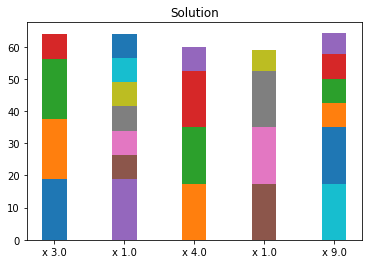

In [9]:
# Solve
ampl.option['solver'] = 'gurobi'
ampl.solve()
# Retrieve solution
cutting_plan = ampl.var['Cut'].getValues()
cutvec = list(cutting_plan.getColumn('Cut.val'))

# Display solution
solution = [
    (patmat[p], cutvec[p])
    for p in range(len(patmat))
    if cutvec[p] > 0
]
cuttingPlot(roll_width, widths, solution)